### Figure generation notebook for MERFISH bulk comparisons with MACA RNA-seq

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import matplotlib as mpl
import numpy as np
import anndata
import scanpy
import string
import seaborn as sns


mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')
# To do: 

In [2]:
# Load data
dataPath = '/mnt/ibm_lg/spatial-seq/MERlin_Analysis/ProcessedResults/BulkCounts'

experimentNames = ['Msliver_VZG116_021121',
                   'Msliver_VZG116_021221',
                   'Msliver_VZG116_021621',
                   'Msliver_VZG116_021721',
                   'MsLiver_Cellbound_VZG116_V1_JH_09-18-2021',
                   'MsKidney_CellBoundary_VZG116_111921',
                   'MsKidney_CellBoundary_VZG116_121021']
bulkCounts = []

for i in range(len(experimentNames)):
    bulkCounts.append(pd.read_csv(os.path.join(
    dataPath, experimentNames[i] + '_BulkRNACounts.csv')))

print('Bulk RNA counts loaded.')

# MACA data
MACA = pd.read_csv('/mnt/ibm_lg/spatial-seq/BulkRNASeqData/190214_A00111_0269_AHH3J3DSXX__190214_A00111_0270_BHHMFWDSXX.csv',
                  index_col=0)
MACA_meta = pd.read_csv('/mnt/ibm_lg/spatial-seq/BulkRNASeqData/MACA_Bulk_metadata.csv')

# Use only mice that are 18 months or younger
#ages = ['6','3','18','1','12','9','15']
ages = ['3'] # Use only 3 month old mice
ind = MACA_meta['characteristics: age'].isin(ages)
samplesToKeep = MACA_meta['Sample name'][ind]
samplesToKeep = [s + '.gencode.vM19' for s in samplesToKeep] # Append the suffix to get the sample names consistent

MACA = MACA.loc[:, samplesToKeep]
MACA_meta = MACA_meta.loc[ind]
print('MACA results loaded.')

Bulk RNA counts loaded.
MACA results loaded.


### Panel A and B: replicate comparisons in MERFISH liver and kidney

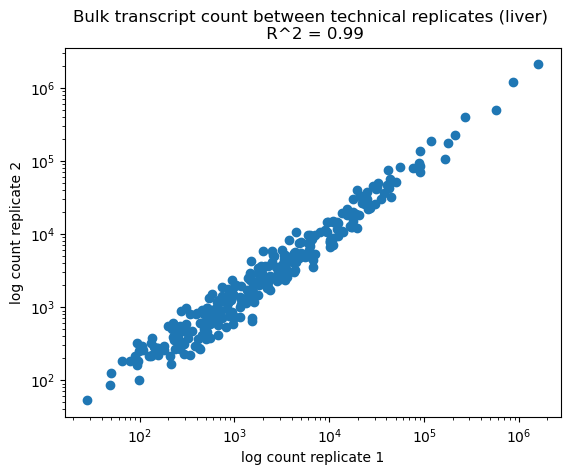

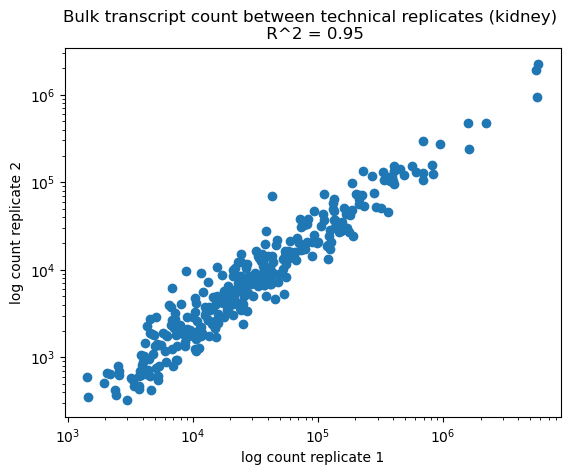

In [3]:
# Update this once we have multiple replicates


VizgenCountsLiver = []
VizgenCountsKidney = []

liver_ind = [0,1,2,3,4] # Indices of liver experiments
kidney_ind = [5,6] # Indices of kidney experiments

for i in liver_ind:
    VizgenCountsLiver.append(bulkCounts[i])
    
for i in kidney_ind:
    VizgenCountsKidney.append(bulkCounts[i])




# Look at correlation between Vizgen replicates

# Liver

#Pick two sample datasets
i = 0
j = 1

# Calculate correlation coefficient
R2_reps_liver = np.corrcoef(VizgenCountsLiver[i]['count'],VizgenCountsLiver[j]['count'])
R2_reps_liver = R2_reps_liver[1,0]

plt.figure()
plt.scatter(VizgenCountsLiver[i]['count'],VizgenCountsLiver[j]['count'])
plt.xlabel('log count replicate 1')
plt.ylabel('log count replicate 2')
plt.xscale('log')
plt.yscale('log')
plt.title('Bulk transcript count between technical replicates (liver) \n R^2 = ' + str(round(R2_reps_liver,2)))
plt.show()

# Kidney

#Pick two sample datasets
i = 0
j = 1

# Calculate correlation coefficient
R2_reps_kidney = np.corrcoef(VizgenCountsKidney[i]['count'],VizgenCountsKidney[j]['count'])
R2_reps_kidney = R2_reps_kidney[1,0]

plt.figure()
plt.scatter(VizgenCountsKidney[i]['count'],VizgenCountsKidney[j]['count'])
plt.xlabel('log count replicate 1')
plt.ylabel('log count replicate 2')
plt.xscale('log')
plt.yscale('log')
plt.title('Bulk transcript count between technical replicates (kidney) \n R^2 = ' + str(round(R2_reps_kidney,2)))
plt.show()

### Panel C: correlation between MERFISH and MACA bulk RNA-seq (VZG116 mouse liver)

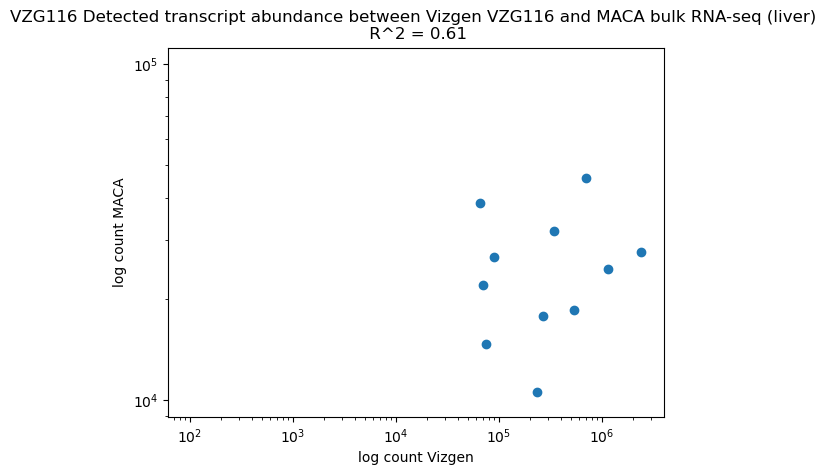

In [4]:
# Format data to be compared
#List of genes to be examined
# genes = VizgenCountsLiver[0]['gene'].copy()
# gene_list = genes.to_list() #Get gene list

# gene_list = [x.lower() for x in gene_list] #Convert to lower case

#MACA plates that are liver tissue
liver_plates = MACA_meta['Sample name'].copy()[MACA_meta['source name'].str.contains('Liver')] #Plates containing liver experiments
liver_plate_strings = liver_plates.to_list() #Convert to list of strings
liver_plate_strings = [s + '.gencode.vM19' for s in liver_plate_strings] #Append to every string to make compatible

#Get gene counts from MACA experiments that are liver tissue (reset gene column from index)
MACA_liver = MACA.copy()[liver_plate_strings].reset_index()

#Get the subset of MACA that intersect with Vizgen genes

#First, make gene list lower case
MACA_liver['gene'] = MACA_liver['gene'].str.lower()

#Calculate the average across all bulk RNA_seq experiments
MACA_liver['average'] = MACA_liver.mean(axis=1,skipna=True,numeric_only=True)

#Calculate average across Vizgen replicates

VizgenLiver = pd.DataFrame(data=np.transpose([VizgenCountsLiver[i]['count'] 
                                          for i in range(len(VizgenCountsLiver))]),
                                         columns=[experimentNames[x] for x in liver_ind])
VizgenLiver['average'] = VizgenLiver.mean(axis=1)
VizgenLiver['gene'] = VizgenCountsLiver[0]['gene'].str.lower()

# Rename Vizgen genes that are inconsistent with MACA
# faim3 - fcmr (y)
# mir205hg - 4631405K08Rik (y)
# tmem27 - Cltrn (y)
# gpr116 - Adgrf5 (y)
# emr1 - Adgre1 (y)
# cybasc3 - Cyb561a3 (y)
# ptrf - Cavin1 (y)
# fam159b - Shisal2b (y)
# 1700011H14RIK - ccdc198 (y)
rename_map = {'faim3':'fcmr',
              'mir205hg':'4631405k08rik',
             'tmem27':'cltrn',
             'gpr116':'adgrf5',
             'emr1':'adgre1',
             'cybasc3':'cyb561a3',
             'ptrf':'cavin1',
             'fam159b':'shisal2b',
             '1700011h14rik':'ccdc198'}
for i in range(VizgenLiver.shape[0]):
    if VizgenLiver.loc[i,'gene'] in rename_map.keys():
        VizgenLiver.loc[i,'gene'] = rename_map[VizgenLiver.loc[i,'gene']]

# Get the intersection_liver with common genes
intersection_liver = VizgenLiver[['average','gene']].merge(MACA_liver[['average','gene']],
                                                           on='gene')
intersection_liver = intersection_liver.rename(columns={'average_x':'Vizgen_avg', 'average_y':'MACA_avg'})


# Plot results

# Correlation coefficient
R2_compare_liver = np.corrcoef(intersection_liver['Vizgen_avg'], intersection_liver['MACA_avg'])
R2_compare_liver = R2_compare_liver[1,0]

# Scatter plot of averages
plt.figure()
plt.scatter(intersection_liver['Vizgen_avg'], intersection_liver['MACA_avg'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log count Vizgen')
plt.ylabel('log count MACA')
plt.title('VZG116 Detected transcript abundance between Vizgen VZG116 and MACA bulk RNA-seq (liver) \n R^2 = ' 
          + str(round(R2_compare_liver,2)))

plt.show()

### Panel D: correlation between MERFISH and MACA bulk RNA-seq (VZG116 mouse kidney)

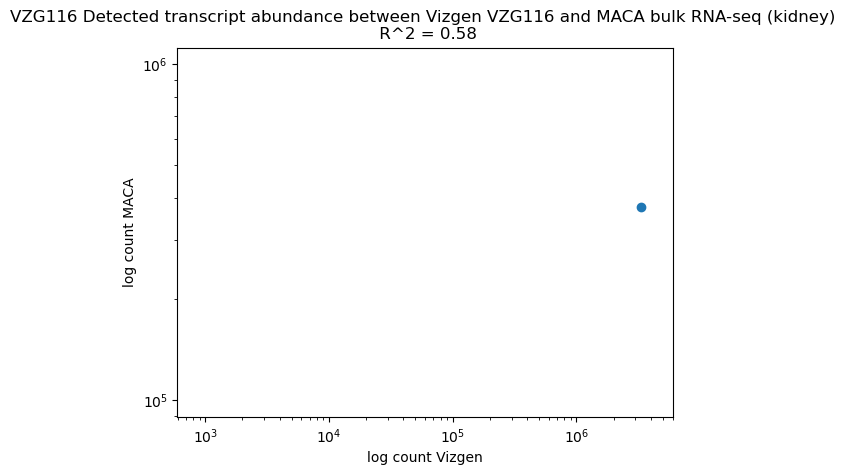

In [5]:
# Format data to be compared
#List of genes to be examined
# genes = VizgenCountsKidney[0]['gene'].copy()
# gene_list = genes.to_list() #Get gene list
# gene_list = [x.lower() for x in gene_list] #Convert to lower case

#MACA plates that are kidney tissue
kidney_plates = MACA_meta['Sample name'].copy()[MACA_meta['source name'].str.contains('Kidney')] #Plates containing kidney experiments
kidney_plate_strings = kidney_plates.to_list() #Convert to list of strings
kidney_plate_strings = [s + '.gencode.vM19' for s in kidney_plate_strings] #Append to every string to make compatible

#Get gene counts from MACA experiments that are kidney tissue (reset gene column from index)
MACA_kidney = MACA.copy()[kidney_plate_strings].reset_index()

#Get the subset of MACA that intersect with Vizgen genes
#First, make gene list lower case
MACA_kidney['gene'] = MACA_kidney['gene'].str.lower()

#Calculate the average across all bulk RNA_seq experiments
MACA_kidney['average'] = MACA_kidney.mean(axis=1,skipna=True,numeric_only=True)

#Calculate average across Vizgen replicates

VizgenKidney = pd.DataFrame(data=np.transpose([VizgenCountsKidney[i]['count'] 
                                          for i in range(len(VizgenCountsKidney))]),
                                         columns=[experimentNames[x] for x in kidney_ind])
VizgenKidney['average'] = VizgenKidney.mean(axis=1)
VizgenKidney['gene'] = VizgenCountsKidney[0]['gene'].str.lower()

# Rename Vizgen genes that are inconsistent with MACA
for i in range(VizgenKidney.shape[0]):
    if VizgenKidney.loc[i,'gene'] in rename_map.keys():
        VizgenKidney.loc[i,'gene'] = rename_map[VizgenKidney.loc[i,'gene']]

# Get the intersection_kidney with common genes
intersection_kidney = VizgenKidney[['average','gene']].merge(MACA_kidney[['average','gene']],
                                                           on='gene')
intersection_kidney = intersection_kidney.rename(columns={'average_x':'Vizgen_avg', 'average_y':'MACA_avg'})


# Plot results

# Correlation coefficient
R2_compare_kidney = np.corrcoef(intersection_kidney['Vizgen_avg'], intersection_kidney['MACA_avg'])
R2_compare_kidney = R2_compare_kidney[1,0]

# Scatter plot of averages
plt.figure()
plt.scatter(intersection_kidney['Vizgen_avg'], intersection_kidney['MACA_avg'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log count Vizgen')
plt.ylabel('log count MACA')
plt.title('VZG116 Detected transcript abundance between Vizgen VZG116 and MACA bulk RNA-seq (kidney) \n R^2 = ' 
          + str(round(R2_compare_kidney,2)))

plt.show()

### Panel E: histogram of ratio of counts per gene in liver (averaged across experiments)

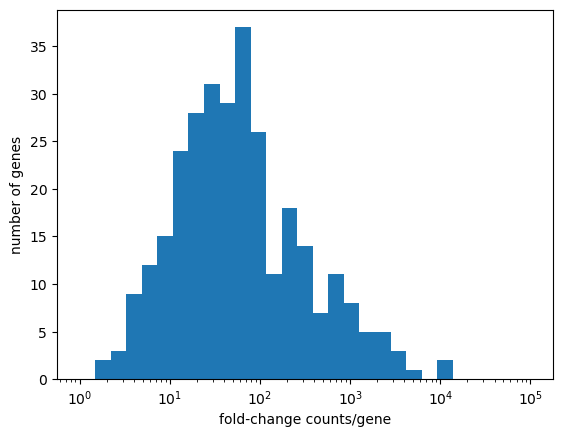

In [6]:
bins = np.logspace(0,5,30)

plt.figure()
plt.hist(intersection_liver['Vizgen_avg'] / intersection_liver['MACA_avg'], bins=bins)
plt.xlabel('fold-change counts/gene')
plt.ylabel('number of genes')
plt.xscale('log')

plt.show()

### Panel F: histogram of counts per gene in kidney (averaged across experiments)

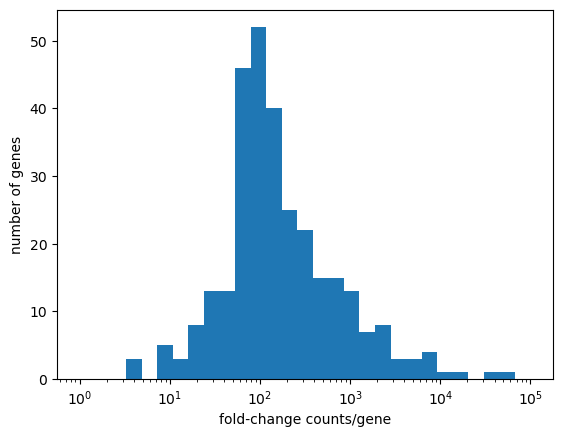

In [7]:
bins = np.logspace(0,5,30)

plt.figure()
plt.hist(intersection_kidney['Vizgen_avg'] / intersection_kidney['MACA_avg'], bins=bins)
plt.xlabel('fold-change counts/gene')
plt.ylabel('number of genes')
plt.xscale('log')

plt.show()

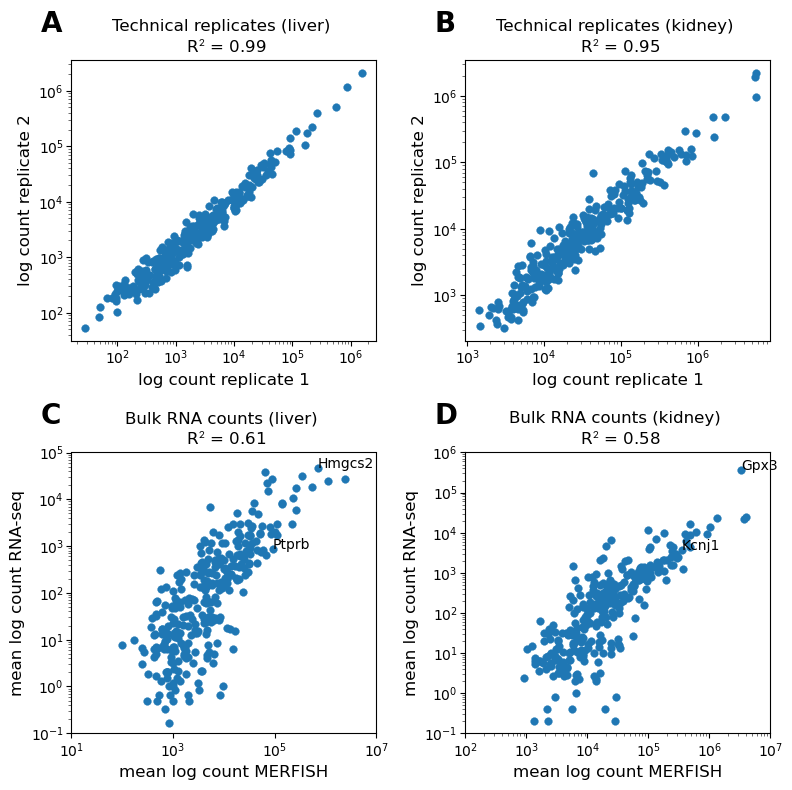

In [37]:
set_plotting_style()
# Plot the whole figure
fig, axes = plt.subplots(2,2, figsize=(8,8))

# Panel A
i = 0
j = 1
ax = axes[0,0]
ax.scatter(VizgenCountsLiver[i]['count'],VizgenCountsLiver[j]['count'])
ax.set_xlabel('log count replicate 1')
ax.set_ylabel('log count replicate 2')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Technical replicates (liver) \n R$^2$ = ' + str(round(R2_reps_liver,2)))

# Panel B
i = 0
j = 1
ax = axes[0,1]
ax.scatter(VizgenCountsKidney[i]['count'],VizgenCountsKidney[j]['count'])
ax.set_xlabel('log count replicate 1')
ax.set_ylabel('log count replicate 2')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Technical replicates (kidney) \n R$^2$ = ' + str(round(R2_reps_kidney,2)))

# Panel C
ax = axes[1,0]
ax.scatter(intersection_liver['Vizgen_avg'], intersection_liver['MACA_avg'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1e1,1e7))
ax.set_ylim((1e-1,1e5))
ax.set_xlabel('mean log count MERFISH')
ax.set_ylabel('mean log count RNA-seq')
ax.set_title('Bulk RNA counts (liver) \n R$^2$ = ' 
          + str(round(R2_compare_liver,2)))

# Annotate some genes
hmgcs2 = intersection_liver[intersection_liver['gene'] == 'hmgcs2']
ptprb = intersection_liver[intersection_liver['gene'] == 'ptprb']

ax.text(hmgcs2['Vizgen_avg'], hmgcs2['MACA_avg'], 'Hmgcs2')
ax.text(ptprb['Vizgen_avg'], ptprb['MACA_avg'], 'Ptprb')

                  
# Panel D
ax = axes[1,1]
ax.scatter(intersection_kidney['Vizgen_avg'], intersection_kidney['MACA_avg'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1e2,1e7))
ax.set_ylim((1e-1,1e6))
ax.set_xlabel('mean log count MERFISH')
ax.set_ylabel('mean log count RNA-seq')
ax.set_title('Bulk RNA counts (kidney) \n R$^2$ = ' 
          + str(round(R2_compare_kidney,2)))

# Annotate some genes
gpx3 = intersection_kidney[intersection_kidney['gene'] == 'gpx3']
kcnj1 = intersection_kidney[intersection_kidney['gene'] == 'kcnj1']

ax.text(gpx3['Vizgen_avg'], gpx3['MACA_avg'], 'Gpx3')
ax.text(kcnj1['Vizgen_avg'], kcnj1['MACA_avg'], 'Kcnj1')

# # Panel E
# ax = axes[2,0]
# bins = np.logspace(0,5,30)

# ax.hist(intersection_liver['Vizgen_avg'] / intersection_liver['MACA_avg'], bins=bins)
# ax.set_xlabel('fold-change mean counts/gene')
# ax.set_ylabel('number of genes')
# ax.set_xscale('log')
# #ax.legend()
# #ax.set_title('counts per gene, liver')

# # Panel F
# ax = axes[2,1]
# bins = np.logspace(0,5,30)

# ax.hist(intersection_kidney['Vizgen_avg'] / intersection_kidney['MACA_avg'], bins=bins)
# ax.set_xlabel('fold-change mean counts/gene')
# ax.set_ylabel('number of genes')
# ax.set_xscale('log')
# #ax.legend()
# #ax.set_title('counts per gene, kidney')

# Label subpanels
axes_flat = axes.flat
for n, ax in enumerate(axes_flat):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

fig.tight_layout()
plt.show()

In [38]:
# Export figures
fig.savefig('../../figures/Fig3_bulkanalysis.svg', transparent=True)
fig.savefig('../../figures/Fig3_bulkanalysis.png', transparent=True)

print('Figures saved.')

Figures saved.
